In [1]:
# COURSE: A deep understanding of deep learning
## SECTION: Metaparameters (activations, optimizers)
### LECTURE: Activation functions comparison
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202305

In [2]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import and process the data

In [3]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=";")
data = data[data["total sulfur dioxide"] < 200]  # drop a few outliers

# z-score all columns except for the column "quality" (which is the target)
cols2zscore = data.keys() # data.keys() is the same as data.columns (just a different name)
cols2zscore = cols2zscore.drop("quality") 
data.loc[:, cols2zscore] = data.loc[:, cols2zscore].apply(stats.zscore) # z-score

# create a new column for binarized (boolean) "quality"
data["boolQuality"] = 0
data.loc[data["quality"] > 5, "boolQuality"] = 1

# Re-organize the data: train/test in DataLoaders

In [4]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()  # .values converts it from pandas.core.frame.DataFrame to numpy.ndarray
labels = torch.tensor( data['boolQuality'].values ).float()  # float() converts bool to float
labels = labels[:,None] # transform to matrix

In [5]:
# use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(
    dataT, labels, test_size=0.1
)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# finally, translate into dataloader objects
batchsize = 32
train_loader = DataLoader(
    train_data, batch_size=batchsize, shuffle=True, drop_last=True
)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

# The Class

In [6]:
# create a class for the model
class ANNwine(nn.Module):
    def __init__(self, actfun):
        super().__init__()

        ### input layer
        self.input = nn.Linear(11, 16)

        ### hidden layers
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 32)

        ### output layer
        self.output = nn.Linear(32, 1)

        # activation funcion to pass through
        self.actfun = actfun

    # forward pass
    def forward(self, x):
        # get activation function type
        actfun = getattr(torch.nn, self.actfun)
        
        x = actfun()(self.input(x))
        x = actfun()(self.fc1(x))
        x = actfun()(self.fc2(x))
        return self.output(x)

## Test the class

In [7]:
# create the model
net = ANNwine('ReLU')

# test a forward pass to see that the dimensions work
fake_data = torch.randn(10,11)
fake_y = net( fake_data )

fake_y


tensor([[-0.0579],
        [-0.0899],
        [-0.0849],
        [-0.0788],
        [-0.0819],
        [-0.0897],
        [-0.0797],
        [-0.0866],
        [-0.0676],
        [-0.1038]], grad_fn=<AddmmBackward0>)

# Train the model

In [8]:
# a function that trains the model

# global parameter
numepochs = 1000


def trainTheModel(model):
    
    # loss function and optimizer
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    # module level registers (to track loss and accuracy)
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):
        
        # turn on training mode
        model.train()

        # batch level registers (to track loss and accuracy)
        batchAcc = []
        batchLoss = []
        
        # loop over training data batches in this epoch (via the DataLoader)
        for X, y in train_loader:
            
            # forward pass and loss
            yHat = model(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # SAVE loss and accuracy for this batch (to average later)
            batchLoss.append(loss.item())
            batchAcc.append(100 * torch.mean(((yHat > 0) == y).float()).item())
            
        # end of batch loop, eval and continue next epoch

        # now that we've trained through the batches, get their average training accuracy
        # SAVE average accuracy and loss for this epoch (trainAcc and losses)
        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        model.eval()
        
        X, y = next(iter(test_loader))  # extract X,y from test dataloader
        
        with torch.no_grad():  # deactivates autograd
            yHat = model(X)
            
        testAcc.append(100 * torch.mean(((yHat > 0) == y).float()).item())

    # function output
    return trainAcc, testAcc, losses

# Parametric plots (activation functions)

In [9]:
# this cell takes ~2 mins

# list activation functions to test (relu variants)
activation_funs = ["ReLU", "ReLU6", "ELU", "LeakyReLU", "PReLU"]

# prepare registers to store results
trainByAct = np.zeros((numepochs, len(activation_funs)))
testByAct = np.zeros((numepochs, len(activation_funs)))
lossByAct = np.zeros((numepochs, len(activation_funs)))

for ai, actfun in enumerate(activation_funs):
    # create a model and train it
    winenet = ANNwine(actfun)
    trainByAct[:, ai], testByAct[:, ai], lossByAct[:, ai] = trainTheModel(winenet)

# Plot the Accuracy and Loss curves

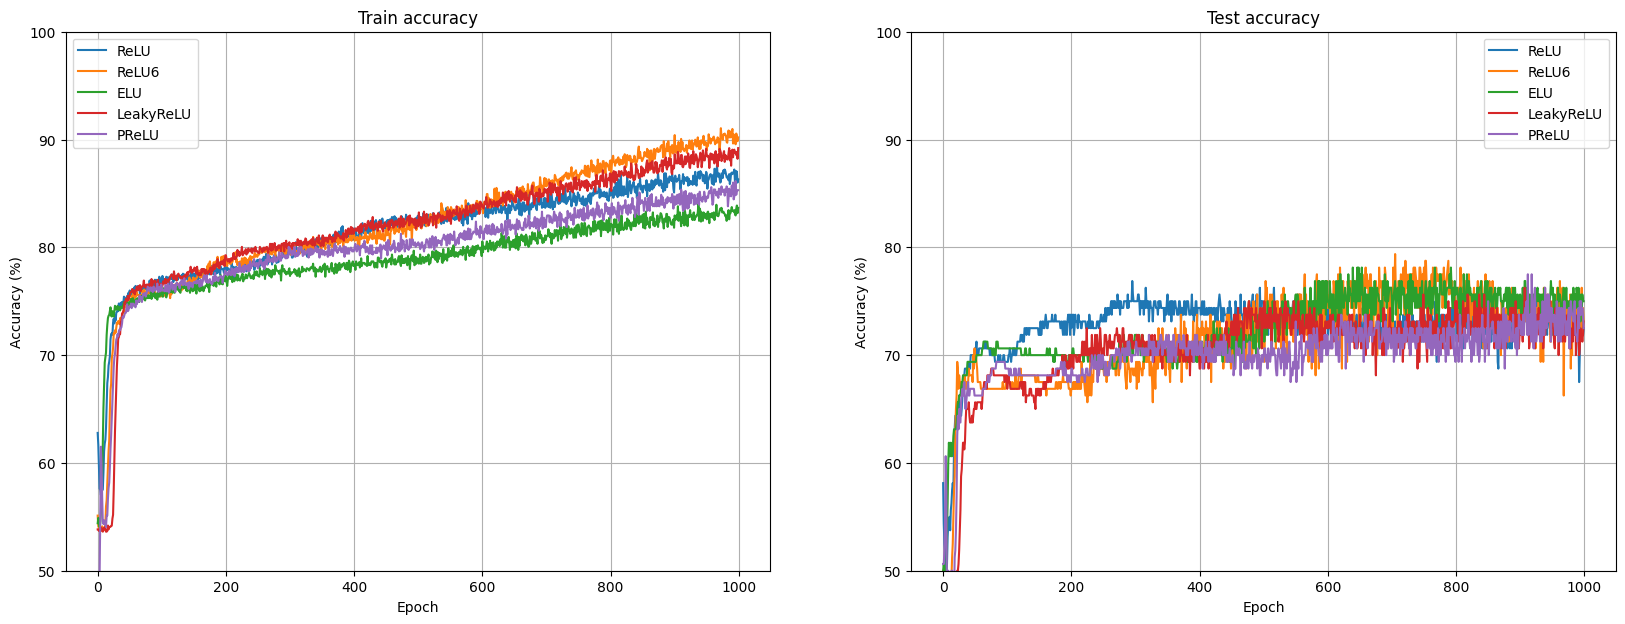

In [10]:
# plot some results
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ax[0].plot(trainByAct)
ax[0].set_title("Train accuracy")
ax[1].plot(testByAct)
ax[1].set_title("Test accuracy")

# common features
for i in range(2):
    ax[i].legend(activation_funs)
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Accuracy (%)")
    ax[i].set_ylim([50, 100])
    ax[i].grid()

plt.show()

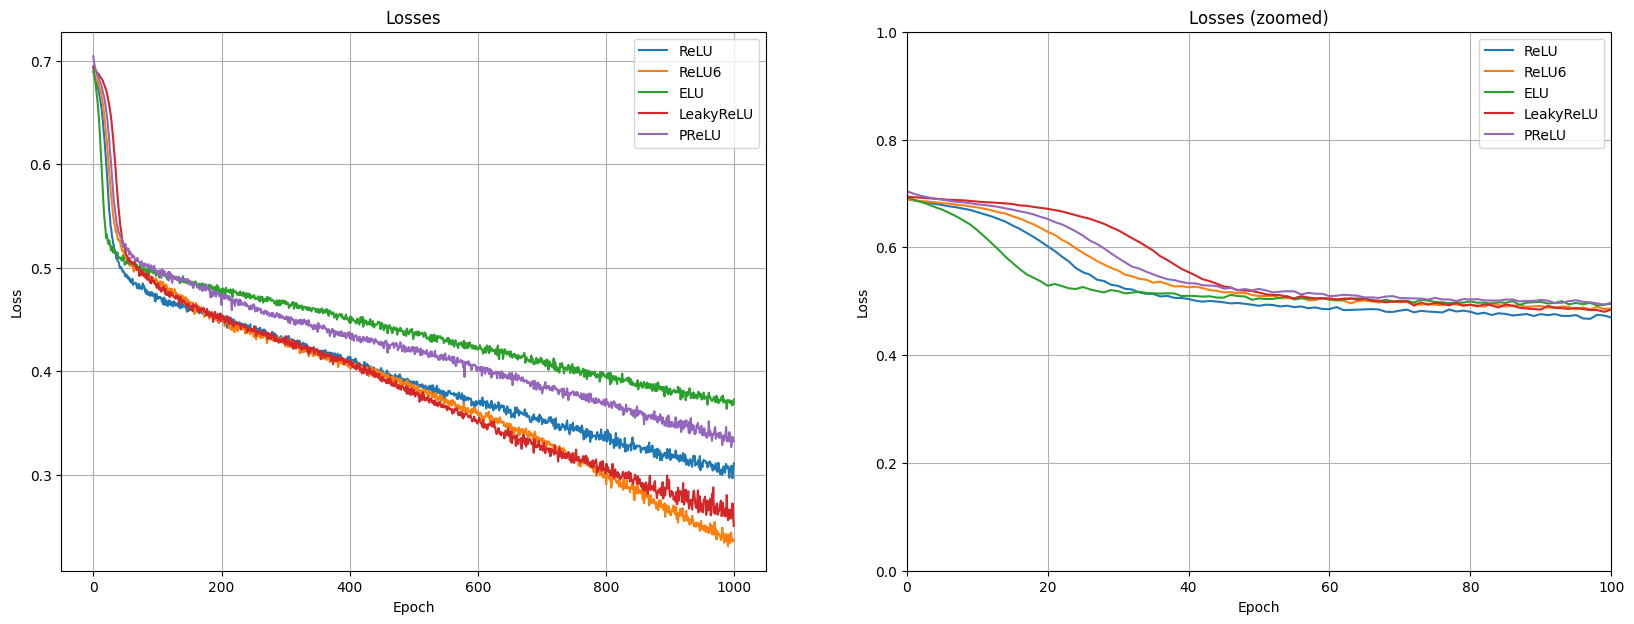

In [11]:
# plot the losses for train and test
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
 
ax[0].plot(lossByAct)
ax[0].set_title("Losses")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend(activation_funs)
ax[0].grid()

ax[1].plot(lossByAct)
ax[1].set_title("Losses (zoomed)")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].set_xlim([0, 100])
ax[1].set_ylim([0, 1])
ax[1].legend(activation_funs)
ax[1].grid()

plt.show()



# Additional explorations

In [12]:
# 1) Lower the learning rate to .001 (instead of .01), and increase the number of epochs to 1500.
#    Do the conclusions about the activation functions change?
# 
# 2) Most of accuracy plots in this course show train and test in separate axes. Modify the visualization code to show 
#    both train and test accuracy in the same plot. What additional visualization considerations are there?
# 